# Planet Labs Image Selection Demo

In [328]:
from timbr import Snapshot
data = Snapshot("/Users/chelm/.timbr/data/San Diego Image Metadata (Planet Labs - RapidEye).h5")

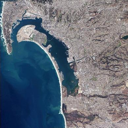

2015-12-12T19:12:10.000000Z 20151212_191210_1154114_RapidEye-5


In [329]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    img = data[i][-1]
    display(Image(data=b64.b64decode(img["thumbnail"]["__data__"]), width=250, height=250))
    print img['properties']['acquired'], img['id']

In [330]:
scene_ids = [
    "20160324_190655_1154114_RapidEye-3",
    "20150326_192901_1154114_RapidEye-5",
    "20140403_193228_1154114_RapidEye-5",
    "20131125_192646_1154114_RapidEye-5",
    "20151212_191210_1154114_RapidEye-5"
]

## Downloading Geotiffs

./san_diego_4_11_16/visual/20160324_190655_1154114_RapidEye-3_visual.tif


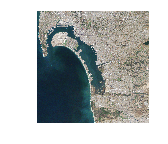

./san_diego_4_11_16/visual/20150326_192901_1154114_RapidEye-5_visual.tif


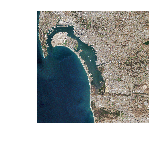

./san_diego_4_11_16/visual/20140403_193228_1154114_RapidEye-5_visual.tif


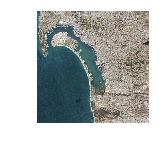

./san_diego_4_11_16/visual/20131125_192646_1154114_RapidEye-5_visual.tif


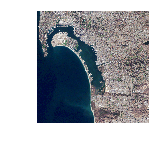

>> Downloading ./san_diego_4_11_16/visual/20151212_191210_1154114_RapidEye-5_visual.tif 55410688why?./san_diego_4_11_16/visual/20151212_191210_1154114_RapidEye-5_visual.tif


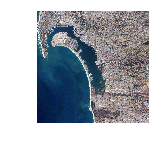

In [331]:
from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response

opener = urllib2.build_opener(NoRedirection)

def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                sys.stdout.write('why?')
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            
            
scenes     = {s['id']: s for i, s in data }
api_key    = "65a347d4358348189a800a5eac3bcde7"
data_dir   = './san_diego_4_11_16'
scene_type = 'visual'                    
scene_meta = [ scenes[i] for i in scene_ids ]
    
for scene in scene_meta:
    filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
    if not os.path.exists(filename):
        get_image(scene, scene_type=scene_type, data_dir=data_dir)
        
    print filename
    fig, ax = plt.subplots(1, figsize=(2,2), facecolor='white')
    ax.axis('off')
    imgplot = plt.imshow(mpimg.imread(filename))
    plt.show() 
     

In [345]:
import rasterio

def bbox_to_pixels(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            ul, lr = [bounds.left, bounds.top], [bounds.right, bounds.bottom]
            r, g, b, a = src.read()
            np_img = np.dstack((r, g, b, a))
            ul_px = xy_from_coords(bbox[0], bbox[3], ul, lr, src.width, src.height)
            lr_px = xy_from_coords(bbox[2], bbox[1], ul, lr, src.width, src.height)
            return ul_px, lr_px
            #return np_img[ul_px[0]:lr_px[0], ul_px[1]:lr_px[1], :]
        
bbox = [483275.7009112152, 3610083.6489744713, 486785.39847831125, 3613762.760762966]
data_dir = './san_diego_4_11_16/visual/'
files = os.listdir(data_dir)
px_box = bbox_to_pixels(bbox,  os.path.join( data_dir, files[1]))
print px_box

((1555, 2147), (2257, 2883))


## Clipping Imagery to the San Diego Naval Base

To compare each image we first clip each one to the same area. We use a BBOX to select array indices that extract an area of interest from each image and stores them as a Numpy nd-array. 

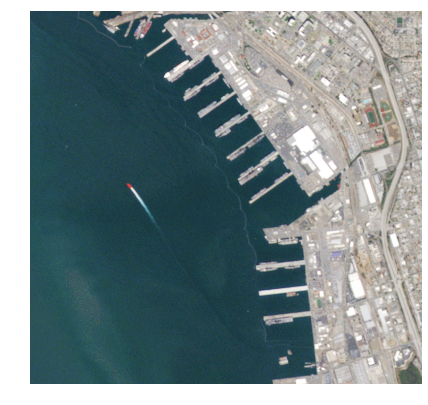

In [334]:
import os
import rasterio
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib.cm as cm 


def xy_from_coords(x_coord, y_coord, ul, lr, width, height):
    x0, x1 = ul[0], lr[0]
    y0, y1 = ul[1], lr[1]
    x_diff = x1 - x0
    y_diff = y0 - y1
    xpx =  ((x1 - x_coord) / x_diff) * width
    if y0 - y_coord == 0.0:
        ypx = height
    elif y_diff != 0:
        ypx = (y0 - y_coord) / y_diff * height
    else:
        ypx = 0
    return int(abs(xpx-width)), int(ypx)


def clip_image(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            ul, lr = [bounds.left, bounds.top], [bounds.right, bounds.bottom]
            r, g, b, a = src.read()
            np_img = np.dstack((r, g, b, a))
            ul_px = xy_from_coords(bbox[0], bbox[3], ul, lr, src.width, src.height)
            lr_px = xy_from_coords(bbox[2], bbox[1], ul, lr, src.width, src.height)
            return np_img[ul_px[0]:lr_px[0], ul_px[1]:lr_px[1], :]
        
def render_array(arr1, arr2=None, width=7, height=7, cmap=plt.cm.jet):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1, cmap=cmap)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')
            

bbox = [483275.7009112152, 3610083.6489744713, 486785.39847831125, 3613762.760762966]

data_dir = './san_diego_4_11_16/visual/'
files = os.listdir(data_dir)
clipped = [clip_image(bbox, os.path.join( data_dir, f )) for f in files]
render_array(clipped[-1])

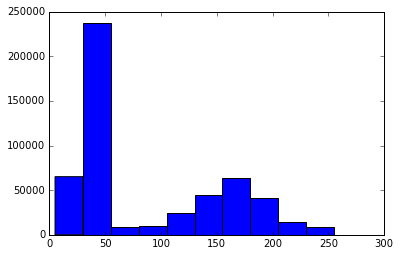

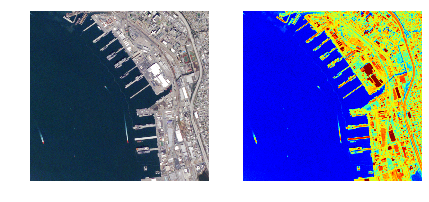

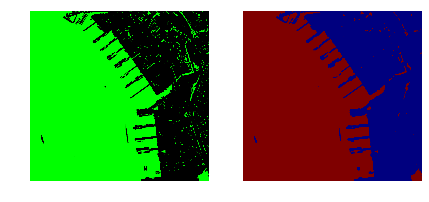

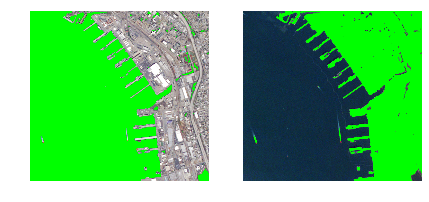

In [335]:
from scipy import ndimage

def average(arr):
    return np.average(arr, axis=2)

def water_mask(arr, threshold=100, x=100, y=300):
    mask = np.copy(arr) 
    mask = np.ndarray(arr.shape + (3,)).astype(np.uint8)
    below = arr < threshold
    above = arr >= threshold
    mask[below] = [0,255,0]
    #mask[above] = 1
    return mask
  
idx = 3
orig_img = np.copy(clipped[idx])
orig_img2 = np.copy(clipped[idx])

# render hist and first mask and avg array
avg = average(orig_img[:,:,0:2])
mask1 = water_mask(avg)
plt.hist(avg.flatten())    
render_array(avg, clipped[idx], width=7, height=7)

#avg_denoised = ndimage.median_filter(avg, 10)
avg_denoised = ndimage.gaussian_filter(avg, 2)
mask2 = water_mask(avg_denoised)
render_array(np.sum(mask2, axis=2), mask1, width=7, height=7)


summed = np.sum(mask2, axis=2)
orig_img[summed == 255] = [0,255,0,255]
orig_img2[summed < 255] = [0,255,0,255]
render_array(orig_img2, orig_img, width=7, height=7)


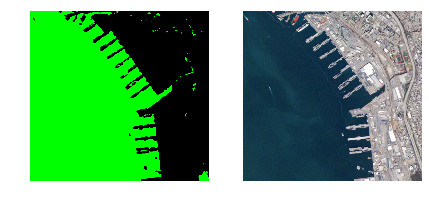

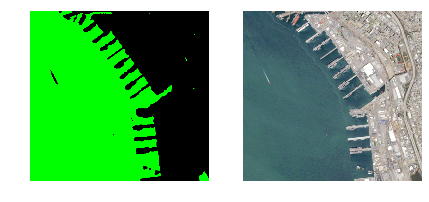

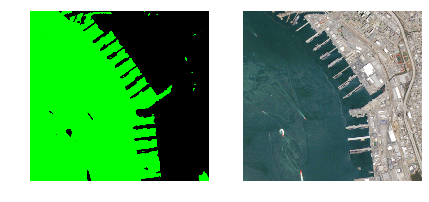

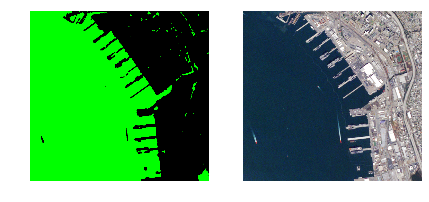

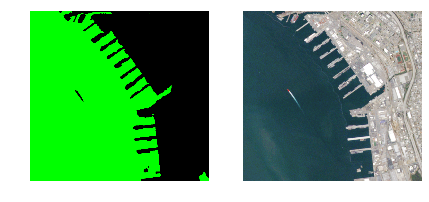

In [336]:
for image_arr in clipped:
    avg = np.average(np.copy(image_arr[:,:,0:2]), axis=2)
    mask = water_mask(ndimage.gaussian_filter(avg, 2))
    render_array(image_arr, mask, width=7, height=7)

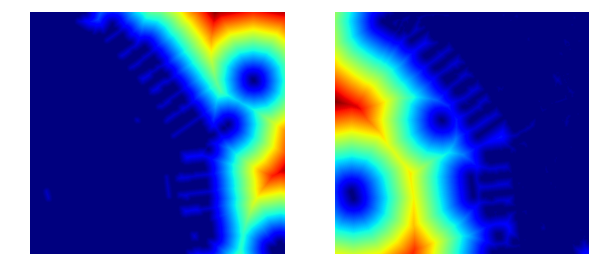

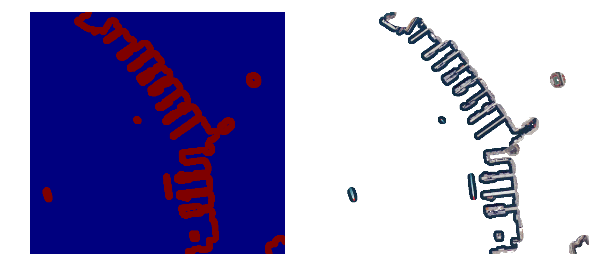

In [337]:
import cv2
import numpy as np
from IPython.display import Image, display

def display_image(image):
    _, png_image = cv2.imencode(".png", image)
    display(Image(data=png_image.tostring()))
    

def buffer_mask(arr, threshold=135, x=100, y=300):
    mask = np.ndarray(arr.shape + (3,)).astype(np.uint8)
    below = arr < threshold
    mask[below] = [255,255,255]
    mask = cv2.morphologyEx(mask[:,:,0], cv2.MORPH_OPEN, kernel=np.ones([3, 3]), iterations=3)
    edm1 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    edm2 = cv2.distanceTransform(mask, cv2.cv.CV_DIST_L2, 5)
    s = (edm2 < 20) & (edm1 < 10)
    mask[s] = 255
    mask[~s] = 0
    #mask = cv2.dilate(mask, kernel=np.ones([1, 1]), iterations=2)

    return mask, edm1, edm2
                                 

    
img = np.copy(clipped[3][:,:,0:3])
avg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
mask, edm1, edm2 = buffer_mask(avg)
                                 
render_array(edm1, edm2, width=10, height=10)

img = np.copy(clipped[3])
img[:,:,3] = mask
render_array(img, mask, width=10, height=10)


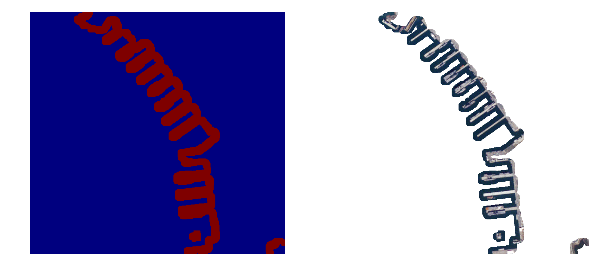

In [338]:
masks = []
for image_arr in clipped:
    avg = np.average(np.copy(image_arr[:,:,0:2]), axis=2)
    mask, edm1, edm2 = buffer_mask(avg, threshold=125)
    masks.append(mask)
    
union_mask = reduce( lambda s,e: s & e, masks )
union_mask = cv2.dilate(union_mask, kernel=np.ones([3, 3]), iterations=3)
binary_mask = union_mask.copy() 
binary_mask[(union_mask > 0)] = 1

#union_mask = cv2.dilate(union_mask, kernel=np.ones([3, 3]), iterations=3)

img = np.copy(clipped[3])
img[:,:,3] = union_mask

render_array(img, union_mask, cmap=plt.cm.gray, width=10, height=10)


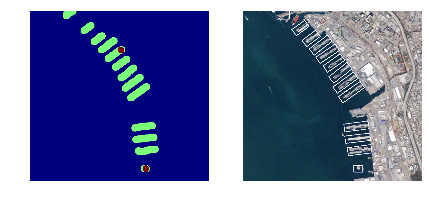

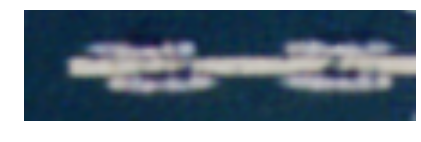

In [339]:

from skimage import measure
from skimage.measure import regionprops
from skimage.morphology import skeletonize, convex_hull_image, medial_axis
from scipy import ndimage

def seg_buffer(im, dist=15):
    mask = im.copy()
    edm1 = cv2.distanceTransform(~im, cv2.cv.CV_DIST_L2, 5)
    s = (edm1 < dist)
    mask[s] = 1
    return mask, edm1

skel = skeletonize(binary_mask).astype(np.int)
#render_array(~skel, width=5, height=5, cmap=plt.cm.gray)

k = np.array([[1,1,1],[1,0,1],[1,1,1]])
ngrid = ndimage.convolve(skel, k, mode='constant') * skel
ngrid[ngrid > 2] = 0
ngrid[(ngrid <= 2) & (ngrid > 0)] = 1

segment_labels = measure.label(ngrid)
segment_props = measure.regionprops(segment_labels)

i=0
buffers = []
for seg in segment_props:
    i += 1
    if (seg.orientation < 0 
        or seg.orientation > 1 
        or seg.solidity < 0.1):
        continue

    buff, edm1 = seg_buffer((segment_labels == i).astype(np.uint8) * 255, dist=15)
    buffers.append(buff)

buffer_sum = reduce( lambda s,e: s + e, buffers )

contours, hierarchy = cv2.findContours( buffer_sum.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
vis = clipped[0].copy()

regions = []
for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) > 0.0:
        rect = cv2.minAreaRect(cnt)
        box = cv2.cv.BoxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(vis,[box],0,(0,0,255),2)
        regions.append({ 'box': box, 'rect': rect, 'bounds': cv2.boundingRect(cnt)})
        #cv2.rectangle(vis,(x,y),(x+w,y+h),0,2)
    
render_array(vis, buffer_sum)

def crop_region(region, img):
    rect = region['rect']
    center = rect[0]
    angle = rect[2]
    size = rect[1]
    size = (int(size[0]), int(size[1]))
     
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    warped = cv2.warpAffine(img, M, dsize=img[:,:,0].shape, flags=cv2.INTER_CUBIC)
    crop = np.ndarray((size[1],size[0],4))

    for i in xrange(4):
        crop[:,:,i] = cv2.getRectSubPix(warped[:,:,i], size, center)

    return crop.astype(np.uint8)


image_regions = [[crop_region(region, img.copy()) for region in regions] for img in clipped]
render_array(image_regions[0][4])

(31, 109)


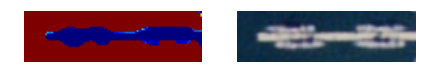

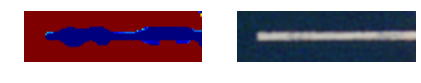

In [340]:
def water_mask2(arr, threshold=135, x=100, y=300):
    mask = np.ndarray(arr.shape + (3,)).astype(np.uint8)
    below = arr < threshold
    mask[below] = [255,255,255]
    mask = cv2.morphologyEx(mask[:,:,0], cv2.MORPH_OPEN, kernel=np.ones([3, 3]), iterations=1)
    return mask

region_masks = []
for i in xrange(0, len(image_regions)):
    #print i
    img = image_regions[i][4]
    avg = np.average(img[:,:,0:2], axis=2)
    region_masks.append( water_mask2(ndimage.gaussian_filter(avg, 2)) )
    


union_mask = reduce( lambda s,e: s & e, region_masks )
print union_mask.shape
render_array(image_regions[0][4], union_mask)
render_array(image_regions[3][4], union_mask)